In [1]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
from time import time
from tqdm import tqdm
import datetime as dt
from collections import Counter


# text processing
import re
with open('stopwords-de_no-parties.json', 'r') as file:
    stopwords_de = json.load(file)


# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)


# Gensim LDA
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs

In [2]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/lda_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,10)]


if read_in:
    parties = parties
    dates = dates
    aug_data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        aug_data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(aug_data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        aug_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


In [3]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda_minimal.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

dumping data to pickle
data dumped


In [5]:
save = False

path_com_corpus = '../Data/lda_minimal_ccorpus.pkl'
path_corpus = '../Data/lda_minimal_corpus.pkl'
path_dic = '../Data/lda_minimal_dic.pkl'

if save:
    
    text = all_data.loc[:, 'full_text']

    document = []
    corpus = []

    for row in text.iteritems():
        index, data = row
        document.append(data)
        
    for doc in document:
        sub_doc = []
        for word in doc.split():
            if ((word.lower() not in stopwords_de)
                and (len(word) > 2)):
                sub_doc.append(word)
        corpus.append(sub_doc)

    common_dictionary = corpora.Dictionary(corpus, prune_at=200000)
    common_corpus = [common_dictionary.doc2bow(t) for t in corpus]
    
    with open(path_com_corpus, 'wb') as fid:
        pickle.dump(common_corpus, fid)
    with open(path_dic, 'wb') as fid:
        pickle.dump(common_dictionary, fid)
    with open(path_corpus, 'wb') as fid:
        pickle.dump(corpus, fid)       
else:
    with open(path_com_corpus, 'rb') as fid:
        common_corpus = pickle.load(fid)
    with open(path_dic, 'rb') as fid:
        common_dictionary = pickle.load(fid)
    with open(path_corpus, 'rb') as fid:
        corpus = pickle.load(fid)

At 20 of 100
At 30 of 100
At 40 of 100
At 50 of 100
At 60 of 100
At 70 of 100
At 80 of 100
At 90 of 100
Process took 84.42701422373453 min


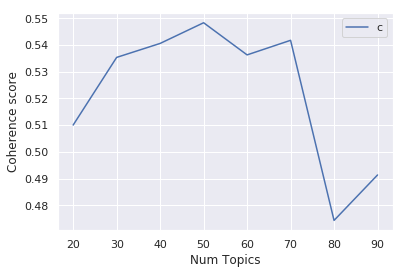

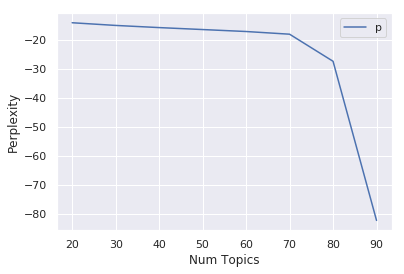

In [6]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Plots coherence score over number of topics
    """
    tick = time()
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, 
                       id2word=dictionary, 
                       num_topics=num_topics, 
                       alpha=0.001, 
                       minimum_probability=0.2,
                       iterations=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(common_corpus))
        print('At {} of {}'.format(num_topics, limit))
    print('Process took {} min'.format((time()-tick)/60))
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    plt.plot(x, perplexity_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity")
    plt.legend(("perplexity"), loc='best')
    plt.show()

compute_coherence_values(common_dictionary, common_corpus, corpus, limit=100, start=20, step=10)

In [8]:
lda = LdaModel(common_corpus, 
               num_topics=83, 
               id2word=common_dictionary, 
               alpha=0.001, 
               random_state=123, 
               minimum_probability=0.2,
               per_word_topics=True,
               iterations=10)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score c_v: ', coherence_lda)

# Compute Coherence Score using u-mass
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score u-mass: ', coherence_lda)

perplexity = lda.log_perplexity(common_corpus)
print('Model perplexity: ', perplexity)

ldavis_prepared = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)

pyLDAvis.display(ldavis_prepared)

KeyboardInterrupt: 